# Schroedinger Equation for Hydrogen Atom


The Schroedinger equation is:

\begin{eqnarray}
(-\frac{\hbar^2}{2m}\nabla^2-\frac{Z e^2}{4\pi\varepsilon_0 r})\psi(\vec{r})=E \psi(\vec{r})
\end{eqnarray}

using ansatz:

$\psi(\vec{r}) = Y_{lm}(\hat{r})\; u(r)/r$

and introducing dimensionless variables:

\begin{eqnarray}
x = \frac{r}{r_B}\\
\varepsilon = \frac{E}{E_0}
\end{eqnarray}
where
\begin{eqnarray}
&& r_B = \frac{4\pi\varepsilon_0 \hbar^2}{m e^2} \approx 0.529 A\\
&& E_0 = \frac{\hbar^2}{2 m r_B^2} == Ry \approx 13.6 eV
\end{eqnarray}

we get the differential equation

\begin{eqnarray}
u''(x)-
\left(\frac{l(l+1)}{x^2}-\frac{2Z}{x}-\varepsilon\right)u(x)=0
\end{eqnarray}

Next we rewrite into the system of first order equations:

\begin{eqnarray}
y = \left(u(x),u'(x)\right)\\
\frac{dy}{dx} = \left(u'(x),u''(x)\right)
\end{eqnarray}

with boundary conditions
\begin{eqnarray}
&&u(0) = 0 \rightarrow \psi(0)<\infty\\
&&u(\infty)=0 \rightarrow \int |\psi(r)|^2 r^2 dr \propto \int u^2(r)dr < \infty
\end{eqnarray}

Because boundary conditions are given at the two ends, we need so-called shooting method

**Shooting algorithm:**

Suppose the two boundary condistions are given at $a$ and $b$, i.e., $u(a)=u(b)=0$. Then

* Choose $u(a)=0$ and $u'(a)=c$, with $c$ some constant.
* Solve for $u(x)$ to the other end, and check if $u(b)=0$.
* Using root finding routine find energy $\varepsilon$ for which u(b)=0. This is the bound state.
* Continue with increasing energy $\varepsilon$ until sufficient number of bound states is found

**Some remarks**

* It turns out that forward integration of the radial Sch. Eq. is unstable. It is better to start integrating from infinity, and then continue down to zero.
* It is better to use logarithmic mesh for radial variable rather than linear. Radial functions need smaller number of points in logarithmic mesh

**The implementation will follow these steps**

<ol>
<li>call SciPy routine <pre>integrate.odeint</pre>  to integrate the one-electron Schroedinger equation. Note that the distance is measured in units of bohr radius and energy units is Rydberg ($1 Ry = 13.6058...eV$)
</li>
<p>
<li> The boundary conditions are $u(0)=0$ and $u(\infty)=0$. 

Use shooting method to obtain  wave functions:
    <ol>
      <li> Use  logarithmic mesh of radial points for integration. Start integrating
        from a large distance ($R_{max} \sim 100$). At $R_{max}$ choose
        $u=0$ and some nonzero (not too large) derivative.</li>
      <li> Integrate the Schroedinger equation down to $r=0$. If
        your choice for the energy $\varepsilon$ corresponds to the bound state, the wave function at $u(r=0)$ will be zero.</li>
    </ol>

<p>
<li>Start searching for the first bound state at sufficiently negative energy (for example $\sim -1.2 Z^2$) and increase energy in sufficiently small steps to bracket all necessary bound states. Ones the wave function at $r=0$ changes sign, use root finding routine, for example  <pre>optimize.brentq,</pre>  to compute zero to very high precision. Store the index and the energy of the bound state for further processing.</li>

<li> Ones bound state energies are found, recompute $u(r)$ for all bound states. Normalize $u(r)$ and plot them.</li>

<li> Compute electron density for various atoms (for example He, Li, ..)  neglecting Coulomb repulsion:
   <p>
     Populate first $Z$ lowest laying electron states and
       compute 
       $\rho = \sum_{lm\in occupied} u_{lm}^2(r)/(4\pi r^2)$. 
       Each state with quantum number $l$ can take $2(2l+1)$
       electrons. Be carefull, if atom is not one of the Nobel gases
       (He, Ne, ...) the last orbital is only partially filled.

</ol>

Recall: 

\begin{eqnarray}
&& y = (u(r), u'(r) )\\
&& dy/dr = (u'(r), u''(r))
\end{eqnarray}

\begin{eqnarray}
u''(r)=
\left(\frac{l(l+1)}{r^2}-\frac{2Z}{r}-\varepsilon\right)u(r)
\end{eqnarray}

In [199]:
from scipy import *
from numpy import *
from scipy import integrate
from scipy import optimize
from numba import jit  # This is the new line with numba

@jit(nopython=True)
def Schroed_deriv(y,r,l,En):
    "Given y=[u,u'] returns dy/dr=[u',u''] "
    (u,up) = y
    return array([up, (l*(l+1)/r**2-2/r-En)*u])

First we try linear mesh and forward integration. It is supposed to be unstable.
We know the ground state has energy $E_0=-1 Ry$ and we should get $1s$ state with integrating Scroedinger equation. 

In [200]:
R = linspace(1e-10,20,500)
l=0
E0=-1.0

ur = integrate.odeint(Schroed_deriv, [0.0, 1.0], R, args=(l,E0))

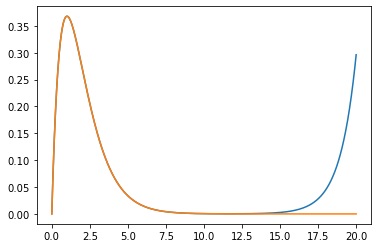

In [201]:
from pylab import *
%matplotlib inline

plot(R,ur[:,0])
plot(R,R*exp(-R)) # expected solution u = r * exp(-r)
show()

Recal `Euler's method` and `Runge Kutta` method

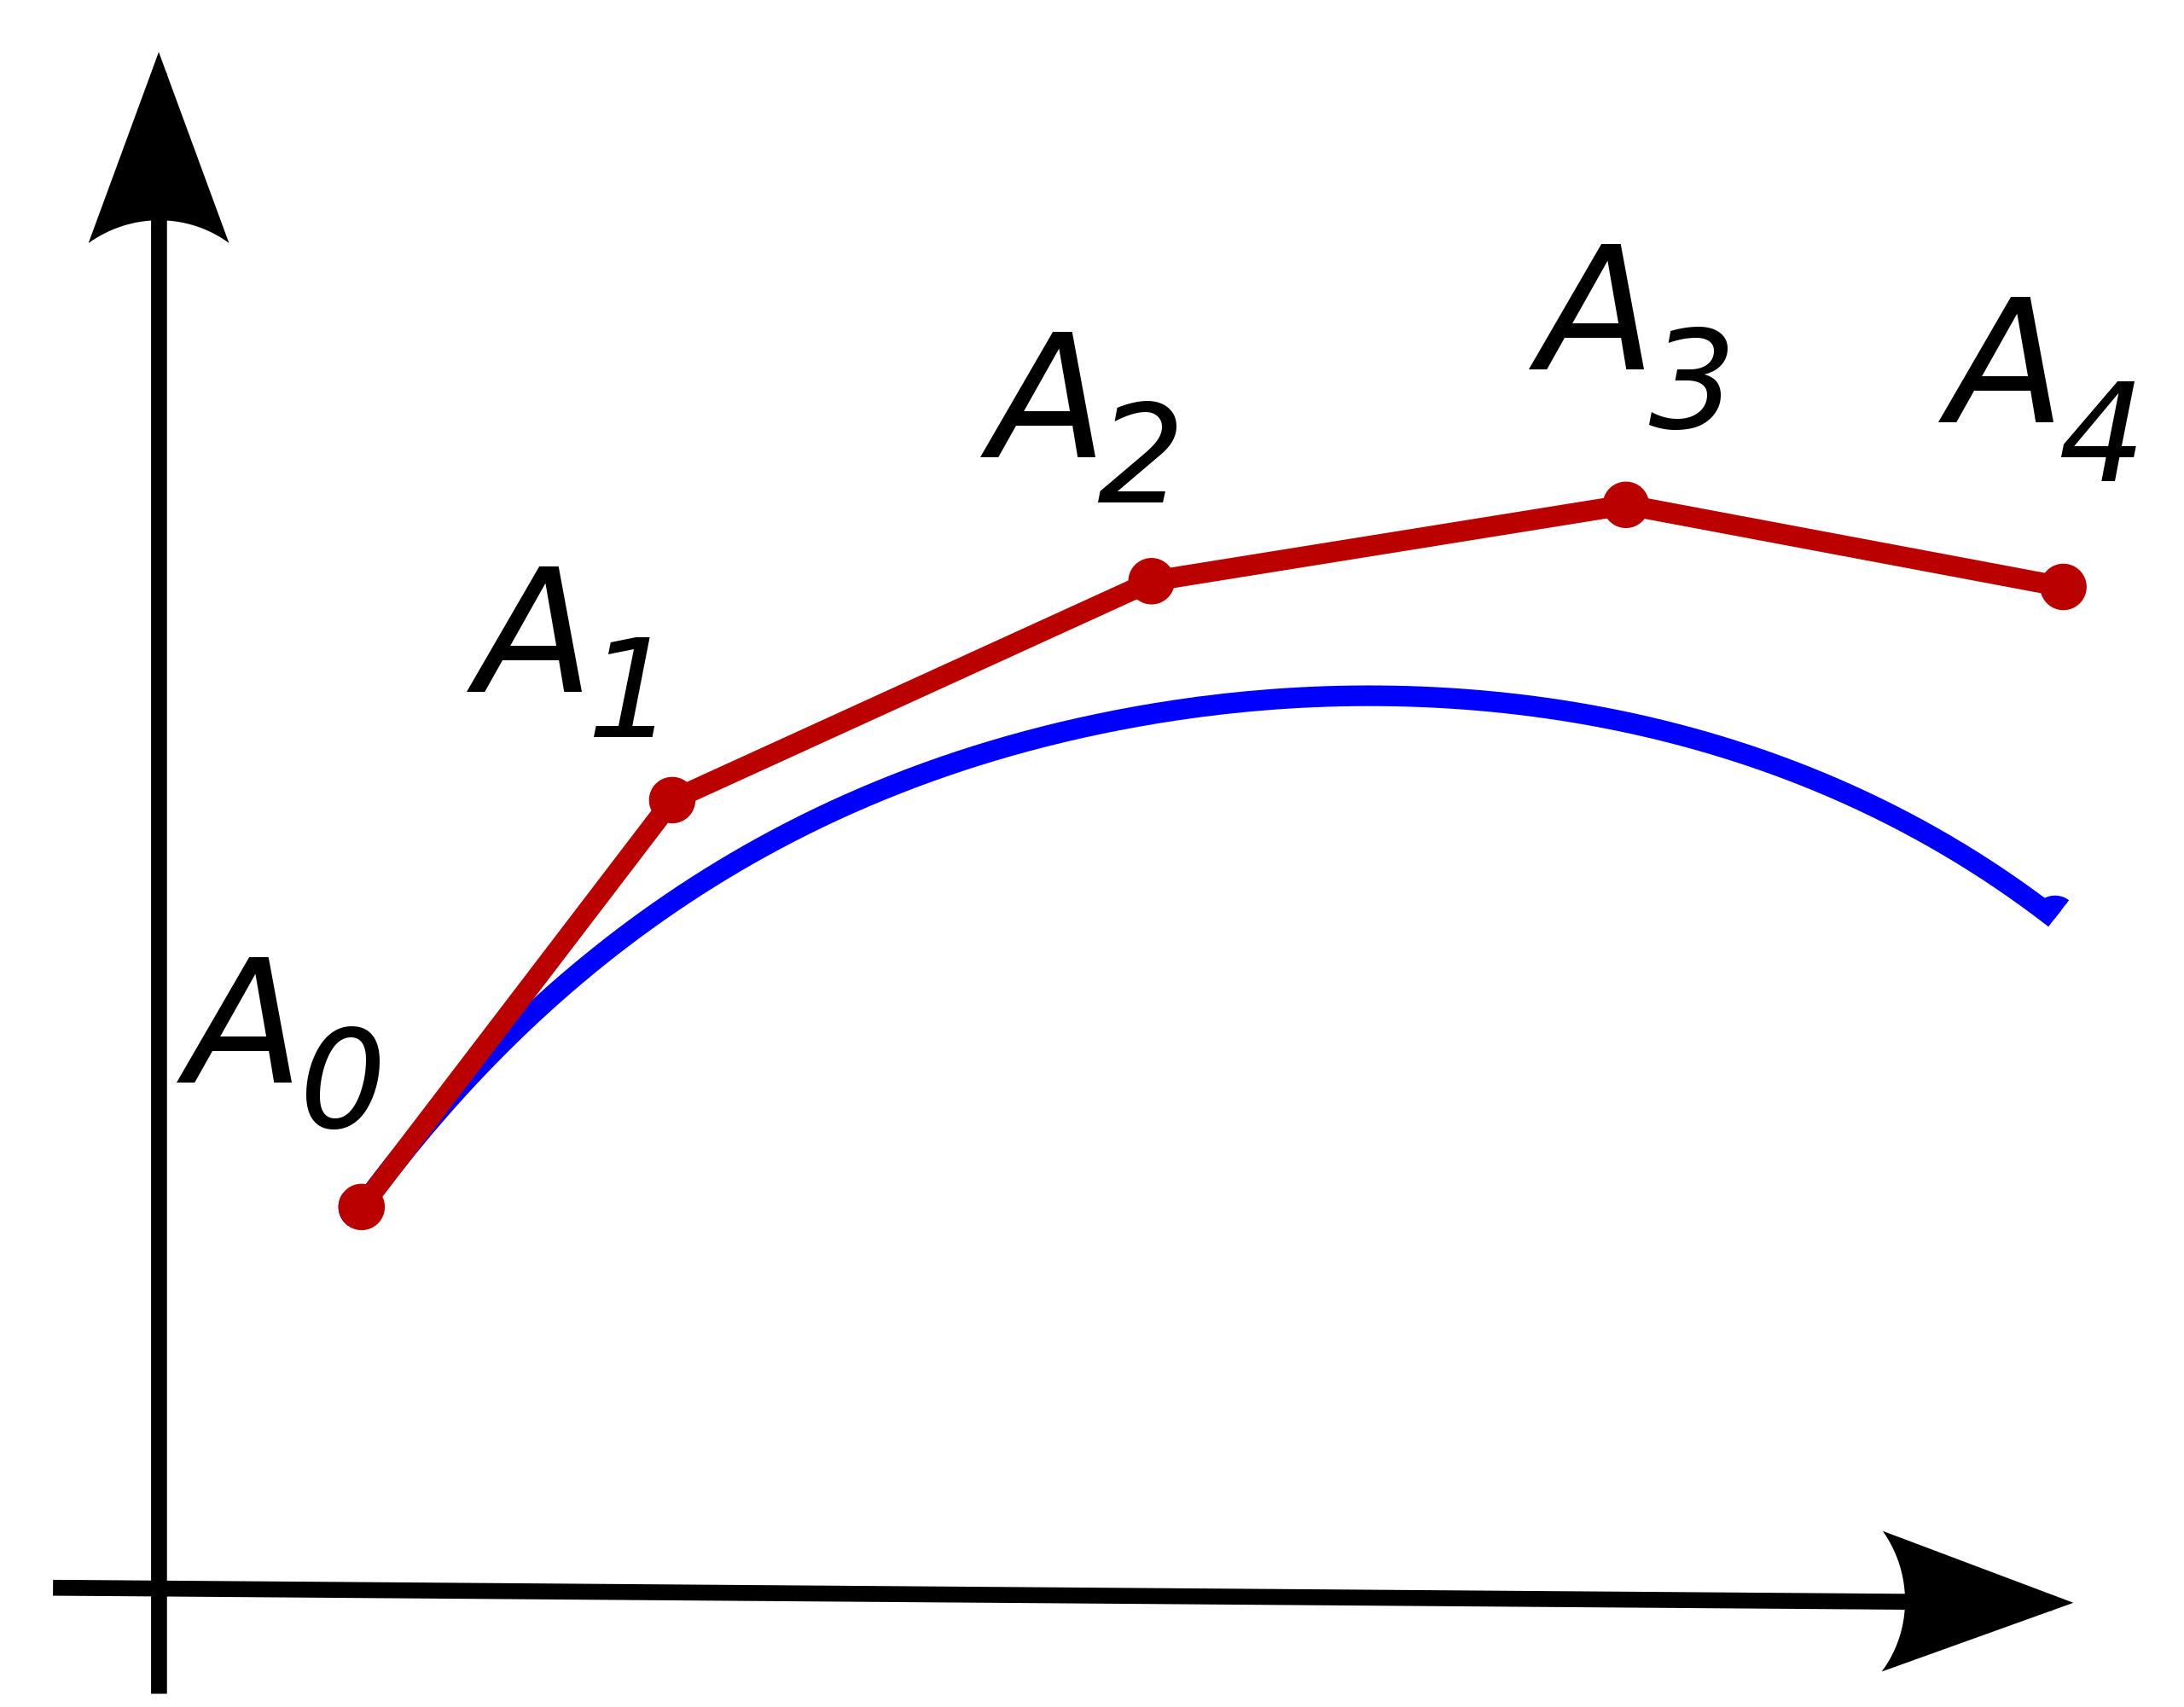

In [202]:
from IPython.display import Image
Image('https://upload.wikimedia.org/wikipedia/commons/thumb/1/10/Euler_method.svg/2560px-Euler_method.svg.png')


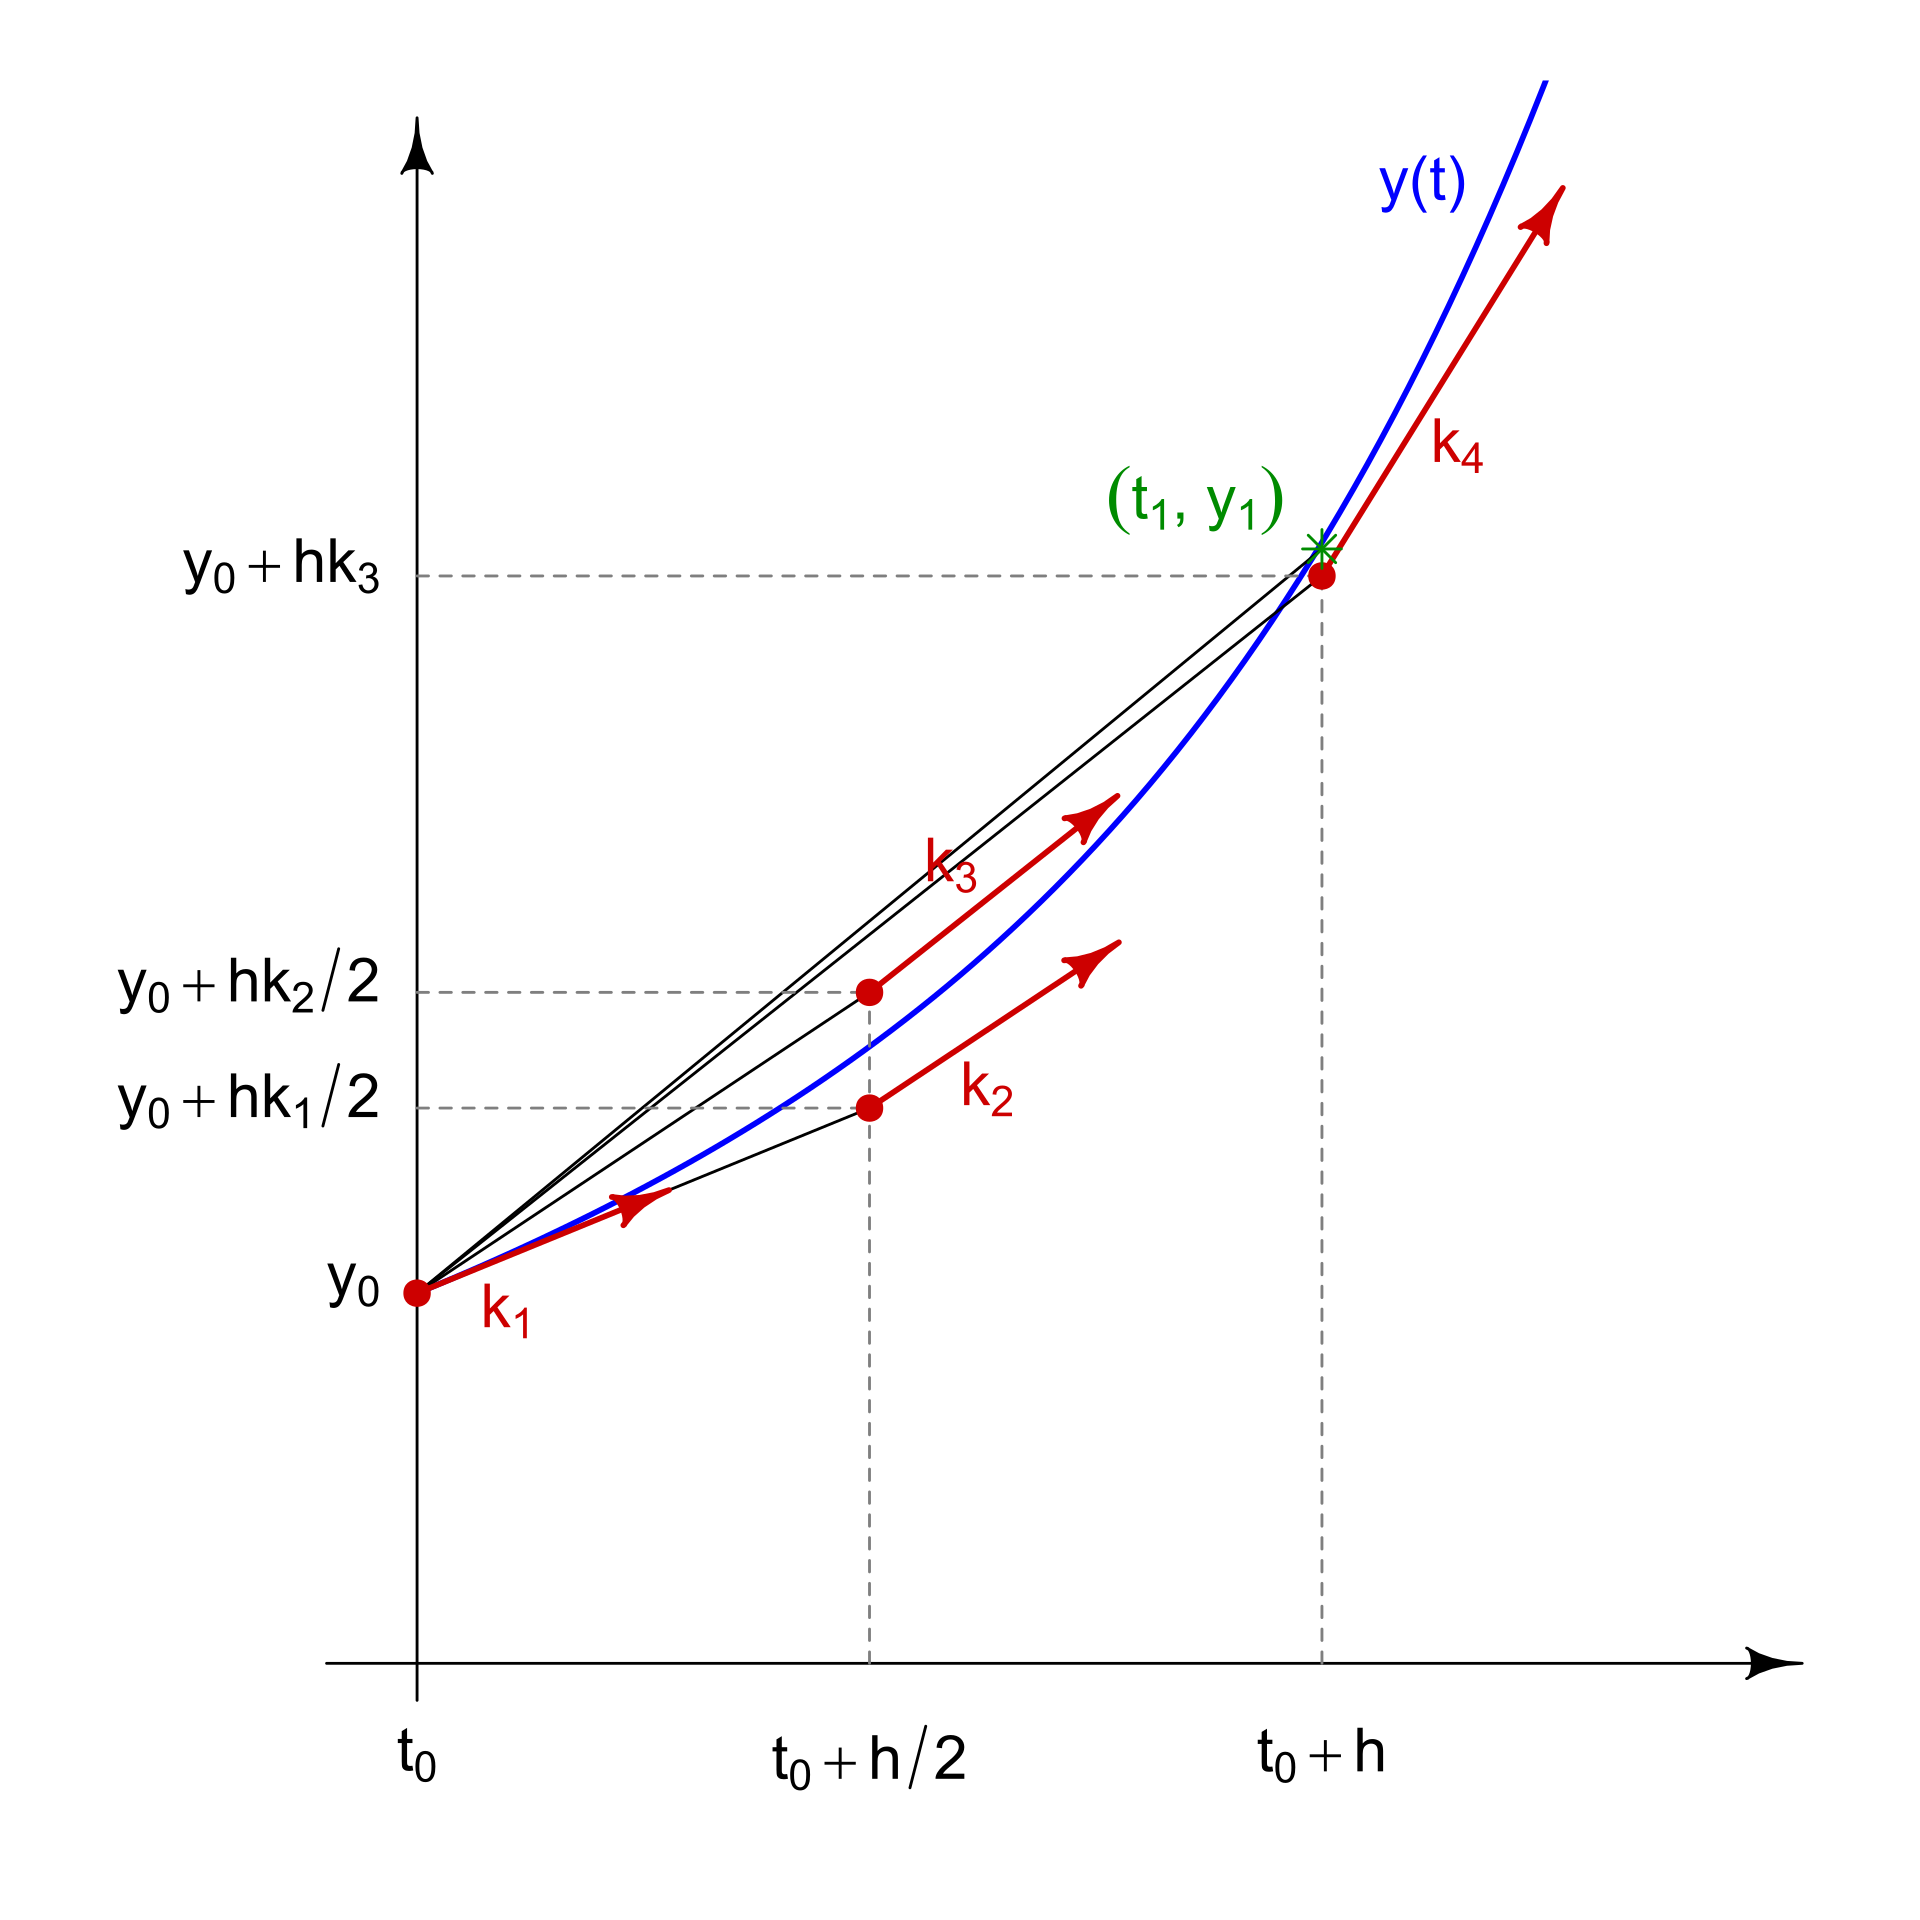

In [203]:
Image('https://upload.wikimedia.org/wikipedia/commons/thumb/7/7e/Runge-Kutta_slopes.svg/1920px-Runge-Kutta_slopes.svg.png')

Indeed the integration is unstable, and needs to be done in opposite direction. Let's try from large R.

In [204]:
R = linspace(1e-10,20,500)
l=0
E0=-1.0
Rb=R[::-1] # invert the mesh

urb = integrate.odeint(Schroed_deriv, [0.0, -1e-5], Rb, args=(l,E0))
ur = urb[:,0][::-1] # we take u(r) and invert it in R.

norm=integrate.simps(ur**2,x=R)
ur *= 1./sqrt(norm)

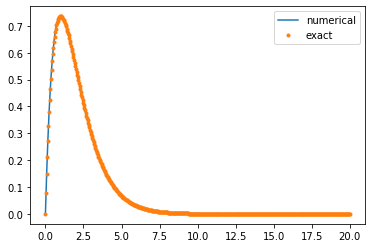

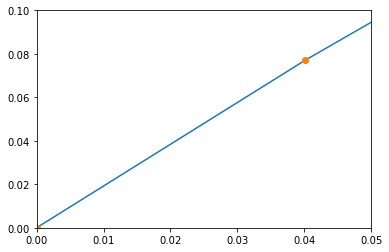

In [205]:
plot(R,ur, label='numerical')
plot(R, R*exp(-R)*2, '.', label='exact') # with proper normalization, exact solution is 2*r*exp(-r)
legend(loc='best')
show()

plot(R,ur, '-')
plot(R, R*exp(-R)*2, 'o')
xlim(0,0.05)
ylim(0,0.10)
show()

Clearly the integration from infinity is stable, and we will use it here.

Logarithmic mesh is better suited for higher excited states, as they extend far away.

Lets create a subroutine of what we learned up to now:

In [206]:
def SolveSchroedinger(En,l,R):
    ur = integrate.odeint(Schroed_deriv, [0.0,-1e-5], R[::-1], args=(l,En))[:,0][::-1]
    ur *= 1./sqrt(integrate.simps(ur**2,x=R))
    return ur

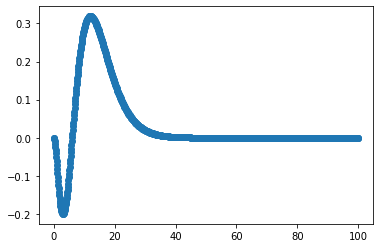

In [207]:
l=1
n=3
En=-1./(n**2)  # 3p orbital


#Ri = linspace(1e-6,20,500)   # linear mesh already fails for this case
Ri = linspace(1e-6,100,1000)
ui = SolveSchroedinger(En,l,Ri)
plot(Ri,ui,'o-', label='linear');

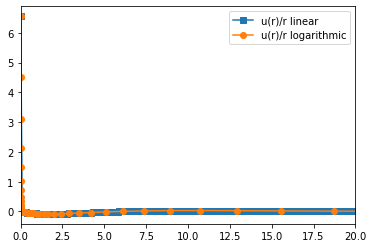

In [208]:
l=1
n=3
En=-1./(n**2)  # 3p orbital


#Ri = linspace(1e-6,20,500)   # linear mesh already fails for this case
Ri = linspace(1e-6,100,1000)
ui = SolveSchroedinger(En,l,Ri)


R = logspace(-6,2.,100)
ur = SolveSchroedinger(En,l,R)


#ylim([0,0.5])
plot(Ri,ui/Ri,'s-', label='u(r)/r linear')
plot(R,ur/R,'o-', label='u(r)/r logarithmic')
xlim([0,20])
#ylim([-0.1,0.1])
legend(loc='best');

**Shooting algorithm:**

The boundary condistions are given at two points $a$ and $b$, i.e., $u(a)=u(b)=0$. 

* **Choose $u(a)=0$ and $u'(a)=c$, with $c$ some constant.**
* **Solve for $u(x)$ to the other end, and evaluate $u(b)$.**

* Using root finding routine find energy $\varepsilon$ for which u(b)=0. This is the bound state.
* Continue with increasing energy $\varepsilon$ until sufficient number of bound states is found

In [209]:
def Shoot(En,R,l):
    ur = integrate.odeint(Schroed_deriv, [0.0,-1e-5], R[::-1], args=(l,En))[:,0][::-1]
    norm=integrate.simps(ur**2,x=R)# normalization is not essential here
    ur *= 1./sqrt(norm)            # once we normalize, the functions are all of the order of unity
    # we know that u(r)~ A r^(l+1), hence, u(r)/r^l ~ A r
    ur = ur/R**l
    # extrapolate to r=0
    f0 = ur[0]
    f1 = ur[1]
    f_at_0 = f0 + (f1-f0)*(0.0-R[0])/(R[1]-R[0])
    return f_at_0

In [210]:
R = logspace(-6,2.2,500)

Shoot(-1.,R,0), Shoot(-1/3**2, R, l=1)

(-7.524027679122589e-09, -368.74657758435194)

**Shooting algorithm:**

The boundary condistions are given at two points $a$ and $b$, i.e., $u(a)=u(b)=0$. 

* Choose $u(a)=0$ and $u'(a)=c$, with $c$ some constant.
* Solve for $u(x)$ to the other end, and evaluate $u(b)$.

* **Using root finding routine find energy $\varepsilon$ for which u(b)=0. This is the bound state.**
* **Continue with increasing energy $\varepsilon$ until sufficient number of bound states is found**

In [211]:
def FindBoundStates(R,l,nmax,Esearch):
    """ R       -- real space mesh
        l       -- orbital quantum number
        nmax    -- maximum number of bounds states we require
        Esearch -- energy mesh, which brackets all bound-states, i.e., every sign change of the wave function at u(0).
    """
    n=0
    Ebnd=[]                     # save all bound states
    u0 = Shoot(Esearch[0],R,l)  # u(r=0) for the first energy Esearch[0]
    for i in range(1,len(Esearch)):
        u1 = Shoot(Esearch[i],R,l) # evaluate u(r=0) and all Esearch points
        if u0*u1<0:
            Ebound = optimize.brentq(Shoot,Esearch[i-1],Esearch[i],xtol=1e-16,args=(R,l)) # root finding routine
            Ebnd.append((l,Ebound))
            if len(Ebnd)>nmax: break
            n+=1
            print('Found bound state at E=%14.9f E_exact=%14.9f l=%d' % (Ebound, -1.0/(n+l)**2,l))
        u0=u1
    
    return Ebnd

In [212]:
Esearch = -1.2/arange(1,20,0.2)**2
Esearch

array([-1.2       , -0.83333333, -0.6122449 , -0.46875   , -0.37037037,
       -0.3       , -0.24793388, -0.20833333, -0.17751479, -0.15306122,
       -0.13333333, -0.1171875 , -0.10380623, -0.09259259, -0.08310249,
       -0.075     , -0.06802721, -0.06198347, -0.05671078, -0.05208333,
       -0.048     , -0.0443787 , -0.04115226, -0.03826531, -0.03567182,
       -0.03333333, -0.03121748, -0.02929688, -0.02754821, -0.02595156,
       -0.0244898 , -0.02314815, -0.02191381, -0.02077562, -0.01972387,
       -0.01875   , -0.01784652, -0.0170068 , -0.01622499, -0.01549587,
       -0.01481481, -0.01417769, -0.01358081, -0.01302083, -0.01249479,
       -0.012     , -0.01153403, -0.01109467, -0.01067996, -0.01028807,
       -0.00991736, -0.00956633, -0.00923361, -0.00891795, -0.00861821,
       -0.00833333, -0.00806235, -0.00780437, -0.00755858, -0.00732422,
       -0.00710059, -0.00688705, -0.006683  , -0.00648789, -0.0063012 ,
       -0.00612245, -0.0059512 , -0.00578704, -0.00562957, -0.00

In [213]:
Esearch = -1.2/arange(1,20,0.2)**2
R = logspace(-6,2.2,500)
nmax=7

Bnd=[]
for l in range(nmax-1):
    Bnd += FindBoundStates(R,l,nmax-l,Esearch)

Found bound state at E=  -1.000000014 E_exact=  -1.000000000 l=0
Found bound state at E=  -0.249999998 E_exact=  -0.250000000 l=0
Found bound state at E=  -0.111111111 E_exact=  -0.111111111 l=0
Found bound state at E=  -0.062500001 E_exact=  -0.062500000 l=0
Found bound state at E=  -0.040000000 E_exact=  -0.040000000 l=0
Found bound state at E=  -0.027777780 E_exact=  -0.027777778 l=0
Found bound state at E=  -0.020407884 E_exact=  -0.020408163 l=0
Found bound state at E=  -0.249999997 E_exact=  -0.250000000 l=1
Found bound state at E=  -0.111111111 E_exact=  -0.111111111 l=1
Found bound state at E=  -0.062500000 E_exact=  -0.062500000 l=1
Found bound state at E=  -0.040000001 E_exact=  -0.040000000 l=1
Found bound state at E=  -0.027777785 E_exact=  -0.027777778 l=1
Found bound state at E=  -0.020407939 E_exact=  -0.020408163 l=1
Found bound state at E=  -0.111111113 E_exact=  -0.111111111 l=2
Found bound state at E=  -0.062500001 E_exact=  -0.062500000 l=2
Found bound state at E=  

In [214]:
sorted(Bnd, key= lambda x: x[1])

[(0, -1.0000000144346817),
 (0, -0.24999999783074844),
 (1, -0.2499999969702904),
 (2, -0.1111111128769895),
 (0, -0.11111111114527727),
 (1, -0.11111111106834594),
 (0, -0.06250000130575296),
 (2, -0.06250000130055285),
 (1, -0.06250000018929516),
 (3, -0.062499999882876356),
 (1, -0.04000000055775173),
 (2, -0.040000000472501886),
 (0, -0.040000000216110485),
 (3, -0.040000000019919),
 (4, -0.0399999999299882),
 (1, -0.027777785464469164),
 (2, -0.027777784587779557),
 (3, -0.027777780427529656),
 (0, -0.02777777958583683),
 (5, -0.02777777784154181),
 (4, -0.027777777755184058),
 (2, -0.02040836406577627),
 (4, -0.020408241028337198),
 (5, -0.020408180238043916),
 (3, -0.020408139788464376),
 (1, -0.020407939294275628),
 (0, -0.020407884400230124),
 (5, -0.01561799418361197),
 (4, -0.015609593699604052),
 (3, -0.015598994601132893),
 (2, -0.015585403553970614),
 (1, -0.015573778892995643),
 (0, -0.015566866041478888)]

In [215]:
def cmpKey(x):
    return x[1] + x[0]/10000.  # energy has large wait, but degenerate energy states are sorted by l

Bnd = sorted(Bnd, key=cmpKey)

In [216]:
Bnd

[(0, -1.0000000144346817),
 (0, -0.24999999783074844),
 (1, -0.2499999969702904),
 (0, -0.11111111114527727),
 (1, -0.11111111106834594),
 (2, -0.1111111128769895),
 (0, -0.06250000130575296),
 (1, -0.06250000018929516),
 (2, -0.06250000130055285),
 (3, -0.062499999882876356),
 (0, -0.040000000216110485),
 (1, -0.04000000055775173),
 (2, -0.040000000472501886),
 (3, -0.040000000019919),
 (4, -0.0399999999299882),
 (0, -0.02777777958583683),
 (1, -0.027777785464469164),
 (2, -0.027777784587779557),
 (3, -0.027777780427529656),
 (4, -0.027777777755184058),
 (5, -0.02777777784154181),
 (0, -0.020407884400230124),
 (1, -0.020407939294275628),
 (2, -0.02040836406577627),
 (3, -0.020408139788464376),
 (4, -0.020408241028337198),
 (5, -0.020408180238043916),
 (0, -0.015566866041478888),
 (1, -0.015573778892995643),
 (2, -0.015585403553970614),
 (3, -0.015598994601132893),
 (4, -0.015609593699604052),
 (5, -0.01561799418361197)]

In [217]:
Z=28 # like Ni
N=0
rho=zeros(len(R))
for (l,En) in Bnd:
    ur = SolveSchroedinger(En,l,R)
    dN = 2*(2*l+1)
    if N+dN<=Z:
        ferm = 1.
    else:
        ferm = (Z-N)/float(dN)
    drho = ur**2 * ferm * dN/(4*pi*R**2) # charge density per solid angle per radius: drho/(dOmega*dr)
    rho += drho
    N += dN
    print('adding state (%2d,%14.9f) with fermi=%4.2f and current N=%5.1f' % (l,En,ferm,N))
    if N>=Z: break

adding state ( 0,  -1.000000014) with fermi=1.00 and current N=  2.0
adding state ( 0,  -0.249999998) with fermi=1.00 and current N=  4.0
adding state ( 1,  -0.249999997) with fermi=1.00 and current N= 10.0
adding state ( 0,  -0.111111111) with fermi=1.00 and current N= 12.0
adding state ( 1,  -0.111111111) with fermi=1.00 and current N= 18.0
adding state ( 2,  -0.111111113) with fermi=1.00 and current N= 28.0


Resulting charge density for a Ni-like Hydrogen atom

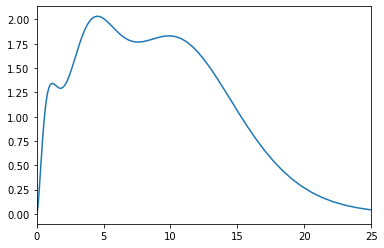

In [218]:
from pylab import *
%matplotlib inline

plot(R,rho*(4*pi*R**2),label='charge density')
xlim([0,25])
show()

## Numerov algorithm

The general purpose integration routine is not the best method for solving the Schroedinger equation, which does not have first derivative terms. 

Numerov algorithm is better fit for such equations, and its algorithm is summarized below. 

The second order linear differential equation (DE) of the form

\begin{eqnarray}
 x''(t) = f(t) x(t) + u(t)
\end{eqnarray}

is a target of Numerov algorithm.

Due to a special structure of the DE, the fourth order error cancels
and leads to sixth order algorithm using second order integration
scheme.


If we expand x(t) to some higher power and take into account the time
reversal symmetry of the equation, all odd term cancel

\begin{eqnarray}
  x(h) = x(0)+h x'(0)+\frac{1}{2}h^2 x''(0)+\frac{1}{3!}h^3
  x^{(3)}(0)+\frac{1}{4!}h^4 x^{(4)}(0)+\frac{1}{5!}h^5 x^{(5)}(0)+...\\
  x(-h) = x(0)-h x'(0)+\frac{1}{2}h^2 x''(0)-\frac{1}{3!}h^3
  x^{(3)}(0)+\frac{1}{4!}h^4 x^{(4)}(0)-\frac{1}{5!}h^5
  x^{(5)}(0)+...
\end{eqnarray}

hence 

\begin{eqnarray}
  x(h)+x(-h) = 2x(0)+h^2 (f(0)x(0)+u(0))+\frac{2}{4!}h^4 x^{(4)}(0)+O(h^6)
\end{eqnarray}


If we are happy with $O(h^4)$ algorithm, we can neglect $x^{(4)}$ term and
get the following recursion relation

\begin{equation}
  x_{i+1} = 2 x_i - x_{i-1} + h^2 (f_i x_i+u_i) +O(h^4).
\end{equation}
where we renaimed
\begin{eqnarray}
&x_{i-1}&= x(-h)\\
&x_i  &= x(0)\\
&x_{i+1} &= x(h)
\end{eqnarray}



But we know from the differential equation that

\begin{equation}
  x^{(4)} = \frac{d^2 x''(t)}{dt^2} = \frac{d^2}{dt^2}(f(t) x(t)+u(t))
\end{equation}
and we will use the well known descrete expression for the second order derivative
\begin{eqnarray}
g''(t) = \frac{g(t+h) - 2 g(t) + g(t-h)}{h^2} + O(h^2)
\end{eqnarray}
which can be approximated by

\begin{equation}
  x^{(4)}= \frac{f_{i+1}x_{i+1}+u_{i+1}-2 f_i x_i -2 u_i+ f_{i-1}x_{i-1}+u_{i-1}}{h^2} + O(h^2)
\end{equation}

Inserting the fourth order derivative into the above recursive equation (forth equation in his chapter), we
get

\begin{equation}
  x_{i+1}-2 x_i+x_{i-1}=h^2(f_i x_i+u_i)+\frac{h^2}{12}(f_{i+1}x_{i+1}+u_{i+1}-2 f_i x_i -2 u_i+ f_{i-1}x_{i-1}+u_{i-1}) + O(h^6)
\end{equation}

If we switch to a new variable $w_i=x_i(1-\frac{h^2}{12} f_i)-\frac{h^2}{12}u_i$
we are left with the following
equation

\begin{equation}
  w_{i+1} = 2 w_i - w_{i-1} + h^2 (f_i x_i + u_i)+O(h^6)
\end{equation}

The variable $x$ needs to be recomputed at each step with
\begin{equation}
x_i=\frac{w_i+\frac{h^2}{12}u_i}{1-\frac{h^2}{12}f_i}.
\end{equation}



In [219]:
@jit(nopython=True)
def Numerovc(f, x0, dx, dh):
    """Given precomputed function f(x), solves for x(t), which satisfies:
          x''(t) = f(t) x(t)
          dx = (dx(t)/dt)_{t=0}
          x0 = x(t=0)
    """
    x = zeros(len(f))
    x[0] = x0
    x[1] = x0+dh*dx
    h2 = dh**2
    h12 = h2/12.
    w0=x0*(1-h12*f[0])
    w1=x[1]*(1-h12*f[1])
    xi = x[1]
    fi = f[1]
    for i in range(2,f.size):
        w2 = 2*w1-w0+h2*fi*xi  # here fi,xi=f1,x1 at the first step
        fi = f[i]              # at this point fi=f2 in the first step
        xi = w2/(1-h12*fi)     # xi is not x2 in the first step
        x[i]=xi                # save x2 into x[2]
        w0,w1 = w1,w2
    return x

For Numerov algorithm we can evaluate derivative part $f(r)$ for all points at once:

Because Schroedinger Eq is:
\begin{eqnarray}
u''(r)=
\left(\frac{l(l+1)}{r^2}-\frac{2Z}{r}-\varepsilon\right)u(r)
\end{eqnarray}
the $f$ function is
\begin{eqnarray}
f(r)=
\left(\frac{l(l+1)}{r^2}-\frac{2Z}{r}-\varepsilon\right)
\end{eqnarray}


In [220]:
def fSchrod(En, l, R):
    return l*(l+1.)/R**2-2./R-En

The Numerov algorithm is much faster, but the price we pay is the mesh has to be linear. We can not use logarithmic mesh in combination with Numerov algorithm.

In [221]:
Rl = linspace(1e-7,50,1000)
l=0
En=-1.
f = fSchrod(En,l,Rl[::-1])     # here we turn mesh R around, so that f is given from large r down to r=0.
ur = Numerovc(f,0.0,1e-7,Rl[1]-Rl[0])[::-1] # turn around the solution, so that it starts with r=0
norm = integrate.simps(ur**2,x=Rl)
ur *= 1/sqrt(abs(norm))

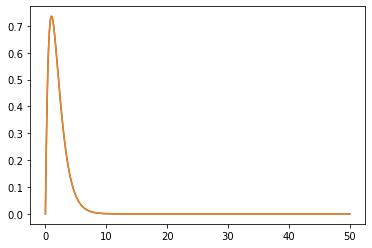

In [222]:
from pylab import *
%matplotlib inline

plot(Rl,ur)
plot(Rl,exp(-Rl)*Rl*2.);

Numerov seems much more precise than odeint, and avoids numerical problems we had before

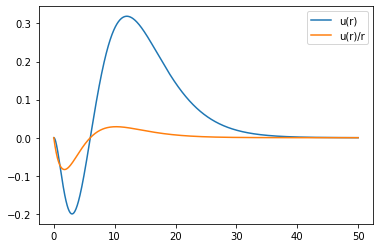

In [228]:
Rl = linspace(1e-7,50,1000)
l=1
En=-1./3**2   # 3p state
f = fSchrod(En,l,Rl[::-1])
ur = Numerovc(f,0.0,-1e-7,-Rl[1]+Rl[0])[::-1]
norm = integrate.simps(ur**2,x=Rl)
ur *= 1/sqrt(abs(norm))

plot(Rl,ur, label='u(r)')
plot(Rl,ur/Rl, label='u(r)/r')
legend(loc='best')
show()

Put it all together

In [229]:
def fSchrod(En, l, R):
    return l*(l+1.)/R**2-2./R-En

def ComputeSchrod(En,R,l):
    "Computes Schrod Eq." 
    f = fSchrod(En,l,R[::-1])
    ur = Numerovc(f,0.0,-1e-7,-R[1]+R[0])[::-1]
    norm = integrate.simps(ur**2,x=R)
    return ur*1/sqrt(abs(norm))

def Shoot(En,R,l):
    ur = ComputeSchrod(En,R,l)
    ur = ur/R**l
    f0,f1 = ur[0],ur[1]
    f_at_0 = f0 + (f1-f0)*(0.0-R[0])/(R[1]-R[0])
    return f_at_0

def FindBoundStates(R,l,nmax,Esearch):
    n=0
    Ebnd=[]
    u0 = Shoot(Esearch[0],R,l)
    for i in range(1,len(Esearch)):
        u1 = Shoot(Esearch[i],R,l)
        if u0*u1<0:
            Ebound = optimize.brentq(Shoot,Esearch[i-1],Esearch[i],xtol=1e-16,args=(R,l))
            #Ebound = optimize.toms748(Shoot,Esearch[i-1],Esearch[i],xtol=1e-16,rtol=3.e-16,args=(R,l))
            Ebnd.append((l,Ebound))
            if len(Ebnd)>nmax: break
            n+=1
            print('Found bound state at E=%14.9f E_exact=%14.9f l=%d' % (Ebound, -1.0/(n+l)**2,l))
        u0=u1
    return Ebnd

def cmpKey(x):
    return x[1] + x[0]/1000.  # energy has large wait, but degenerate energy states are sorted by l


In [230]:
def ChargeDensity(Bnd,R,Z):
    rho = zeros(len(R))
    N=0.
    for (l,En) in Bnd:
        ur = ComputeSchrod(En, R, l)
        dN = 2*(2*l+1)
        if N+dN <= Z:
            ferm = 1.
        else:
            ferm = (Z-N)/float(dN)
        drho = ur**2 * ferm * dN/(4*pi*R**2)  # contribution to density per unit volume
        rho += drho
        N += dN
        print('adding state', (l,En), 'with fermi=', ferm)
        if  N>=Z: break
    return rho

Found bound state at E=  -0.999922109 E_exact=  -1.000000000 l=0
Found bound state at E=  -0.249990190 E_exact=  -0.250000000 l=0
Found bound state at E=  -0.111108201 E_exact=  -0.111111111 l=0
Found bound state at E=  -0.062498772 E_exact=  -0.062500000 l=0
Found bound state at E=  -0.039999314 E_exact=  -0.040000000 l=0
Found bound state at E=  -0.250000016 E_exact=  -0.250000000 l=1
Found bound state at E=  -0.111111117 E_exact=  -0.111111111 l=1
Found bound state at E=  -0.062500003 E_exact=  -0.062500000 l=1
Found bound state at E=  -0.039999959 E_exact=  -0.040000000 l=1
Found bound state at E=  -0.111111111 E_exact=  -0.111111111 l=2
Found bound state at E=  -0.062500000 E_exact=  -0.062500000 l=2
Found bound state at E=  -0.039999977 E_exact=  -0.040000000 l=2
Found bound state at E=  -0.062500000 E_exact=  -0.062500000 l=3
Found bound state at E=  -0.039999992 E_exact=  -0.040000000 l=3
adding state (0, -0.9999221089559618) with fermi= 1.0
adding state (0, -0.2499901902065299

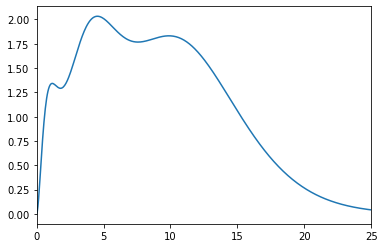

In [237]:
Esearch = -1.2/arange(1,20,0.2)**2
R = linspace(1e-8,100,2000)

nmax=5
Bnd=[]
for l in range(nmax-1):
    Bnd += FindBoundStates(R,l,nmax-l,Esearch)
Bnd = sorted(Bnd, key=cmpKey)

Z=28  # Like Ni ion

rho = ChargeDensity(Bnd,R,Z)

plot(R,rho*(4*pi*R**2),label='charge density')
xlim([0,25])
show()

It seems with Numerov we are getting substantial error-bar for the energy of 1s state. We could increase the number of points in the mesh, but the error decreases only linearly with the number of points used.

Where is the problem? What should be done?

In [241]:
optimize.brentq(Shoot,-1.1,-0.99,xtol=1e-16,args=(R,0))

-0.9999221089559636

Check that approximate solution gives smaller wave function at zero than exact energy, which confirms that root finding routine works fine.

In [239]:
Shoot(-1.0,R,l=0), Shoot(-0.9999221089559636,R,l=0)

(9.742378702111357e-10, 1.6493981414307372e-20)

Let's check how the function looks like near zero

(0.0, 0.4)

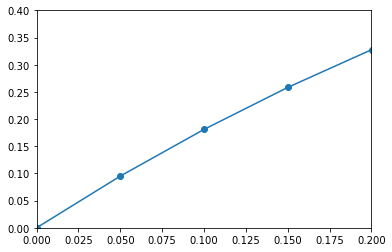

In [242]:
ur = ComputeSchrod(-1.0,R,0)
plot(R,ur,'o-')
xlim(0,0.2)
ylim(0,0.4)

Idea: The mesh is very sparse near zero, and in the range of the first few points, the curve is not linear enough. Linear extrapolation gives the error.

Can we do better?

Let's use cubic extrapolation with first 4 points.

In [251]:
def Shoot2(En,R,l):
    ur = ComputeSchrod(En,R,l)
    ur = ur/R**l
    poly = polyfit(R[:4], ur[:4], deg=3)
    return polyval(poly, 0.0)

In [252]:
Shoot2(-1,R,l=0), Shoot2(-0.9999221089559636,R,l=0)

(7.042025679289644e-13, -9.661386030997263e-10)

In [253]:
optimize.brentq(Shoot2,-1.1,-0.9,xtol=1e-16,args=(R,0))

-0.999999943269074

Indeed we get $10^{-8}$ error as compared to $10^{-5}$ error before.
So, the extrapolation must be improved to reduce the error.